In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'

%pip install bdpy kornia timm tqdm



Mounted at /content/drive
/content/drive/My Drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 928 kB/s 
     |████████████████████████████████| 551 kB 26.4 MB/s 
     |████████████████████████████████| 549 kB 83.9 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 182 kB 91.9 MB/s 


In [2]:
import csv
import fnmatch
import glob
import os
from datetime import datetime

import PIL.Image
# import caffe
import lmdb
import numpy as np
import pandas as pd
# from PIL.Image import resize as imresize

import bdpy
import lmdb
import pickle
from torchvision.transforms import Resize
import torchvision.transforms.functional as TF
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms.functional import equalize,rgb_to_grayscale
from kornia.enhance import equalize_clahe
import kornia
import matplotlib.pyplot as plt
import timm
import tqdm
from tqdm.autonotebook import tqdm
import itertools
import pickle as pkl
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [3]:
class ImageObject:
    def __init__(self, image):
        # Dimensions of image for reconstruction - not really necessary 
        # for this dataset, but some datasets may include images of 
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]
        self.image = image.tobytes()

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)
    
    


def create_lmdb(image_dir = "", output_dir = "",image_file_pattern ='*.JPEG', img_size = 248):
    """ Stores images to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
    """
    if os.path.exists(output_dir):
        print('%s already exists. Skipped.' % output_dir)
    else:
        os.makedirs(output_dir)
        
    image_list = glob.glob(os.path.join(image_dir, "*"))
    print(len(image_list))
    map_size = map_size = 100 * 1024 * len(image_list) * 10 * 10

    # Create a new LMDB environment
    env = lmdb.open(output_dir, map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        count = 0
        for image_file in image_list:
            image_id = os.path.splitext(os.path.basename(image_file))[0]
            image = PIL.Image.open(image_file)
            image = np.array(image)
             # Monochrome --> RGB
            if image.ndim == 2:
                img_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=image.dtype)
                img_rgb[:, :, 0] = image
                img_rgb[:, :, 1] = image
                img_rgb[:, :, 2] = image
                image = img_rgb

            img_obj = ImageObject(image)
            key = image_id
            txn.put(key.encode("ascii"), pickle.dumps(img_obj))
            count = count + 1
            if count %1000 == 0:
                print(count)
    env.close()


In [ ]:
# Run once to setup lmdb database
# create_lmdb("data/images/training", "naturalimages")
# create_lmdb("data/images/test", "test1")
#create_lmdb("ArtificialImage", "lmdb_artificial_images", image_file_pattern ='*.tiff')
# create_lmdb("natural_images/test", "naturalimages")


1200
1000
naturalimages already exists. Skipped.
5103
1000
2000
3000
4000
5000


In [4]:
from torchvision.utils import ImageFont
import cv2

batch_size = 64
momentum = 0.9
lr = 0.01
epochs = 20
log_interval = 100

class ImageDataset(Dataset):

    def __init__(self, lmdb_path="",start=0,end=None, scale_factor=5):  
        self.env = lmdb.open(lmdb_path)

        with self.env.begin() as txn:
            keys = list(txn.cursor().iternext(values=False))
            if not end:
              end = len(keys)
            self.image_labels = keys[start:end]
            self.image_labels = keys[start:end] * scale_factor
            self.transform = transforms.Compose([transforms.Resize((128,128)),
                                      # transforms.Normalize()          
                                    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
                                    
                                    ])
        
    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):

        image_label = self.image_labels[idx]
        with self.env.begin(write=True) as txn:
            image = pickle.loads(txn.get(image_label)).get_image()
            image = torch.from_numpy(image)
            image = torch.permute(image, (2,0,1))
            image = transforms.functional.convert_image_dtype(image,dtype=torch.float64)
            image = self.transform(image)

        return image



In [5]:
#images data loaders
                 
natural_images = "naturalimages"
train_dataset = ImageDataset(lmdb_path=natural_images ,start=0,end=5500)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, num_workers=10,shuffle=True)

val_dataset = ImageDataset(lmdb_path=natural_images ,start=5500,end=6000)

valloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, num_workers=10,shuffle=True)

test_dataset = ImageDataset(lmdb_path=natural_images ,start=0,end=None)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=0, shuffle=True)


In [5]:
artificial_images = "lmdb_artificial_images"
train_dataset = ImageDataset(lmdb_path=artificial_images ,start=10,end=None, scale_factor=50)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, num_workers=10,shuffle=True)

val_dataset = ImageDataset(lmdb_path=artificial_images ,start=0,end=5,scale_factor=20)

valloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, num_workers=10,shuffle=True)

test_dataset = ImageDataset(lmdb_path=artificial_images ,start=5,end=10,scale_factor=20)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=2, num_workers=0, shuffle=True)


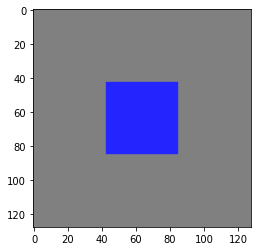

In [7]:
for batch_idx, image in enumerate(trainloader):
    plt.imshow(image[0].squeeze().permute(1,2,0), interpolation='nearest')
    plt.show()
    break

In [6]:
class CFG:
    debug = False
    batch_size = 32
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [7]:
class MriEncoder(nn.Module):
    def __init__(self,encode_dim=256):
        super().__init__()
        
        self.fc = nn.Sequential(
                    nn.Linear(11726, 8192),
                    nn.BatchNorm1d(8192),
                    nn.ReLU(), 
                
                    nn.Linear(8192, 4096),
                    nn.BatchNorm1d(4096),
                    nn.ReLU(),
                    nn.Linear(4096, 2048),
                    nn.BatchNorm1d(2048),
                    nn.ReLU(),
                    nn.Linear(2048, 1024),
                    nn.BatchNorm1d(1024),
                    nn.ReLU(),
                    nn.Linear(1024, 512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Linear(512, encode_dim),
                    nn.BatchNorm1d(256),
                    nn.Sigmoid(),                  
                    )
        

    def forward(self, input):
        input = self.fc(input)
        return input

In [8]:

class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, encode_dim = 1024, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        self.resnet = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.resnet.parameters():
            p.requires_grad = trainable


        self.fc1 = nn.Sequential(
                    nn.Linear(2048, 1024),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU())
        
        self.fc2 = nn.Sequential(
                    nn.Linear(1024, encode_dim),
                    nn.LeakyReLU())
        
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, encode_dim),
                    nn.Sigmoid())
        
        
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        # x = x.type(torch.float64).to(device)
        x = self.resnet(x)
        x = self.fc1(x)
        mu =  self.fc2(x)
        logvar = self.fc3(x)
        z = self.reparameterise(mu, logvar)
        return z, mu, logvar


In [9]:
class ImageDecoder(nn.Module):
    """
    Reconstrcut images from embeddings
    """

    def __init__(
        self, encode_dim = 1024, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        

        self.fc1 = nn.Sequential(
                    nn.Linear(encode_dim, 1024),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU())
        

        self.fc2 = nn.Sequential(
                    nn.Linear(1024, 64 * 4 * 4),
                    nn.BatchNorm1d(64*4*4),
                    nn.LeakyReLU())
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.LeakyReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.LeakyReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.LeakyReLU()   
        )

        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.LeakyReLU()   
        )
        
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()   
        )

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x).view(-1, 64, 4, 4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear')
        return x

In [10]:
# img_encoder = ImageEncoder().to(device)
# img_decoder = ImageDecoder().to(device)
experiment = "variational-autoencoder-shapes"
img_decoder = ImageDecoder().to(device)
img_encoder = ImageEncoder().to(device)

# img_decoder.load_state_dict(torch.load("img_decoder_{0}.pt".format(experiment), map_location=CFG.device))
# img_encoder.load_state_dict(torch.load("img_encoder_{0}.pt".format(experiment), map_location=CFG.device))


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [11]:
params = [
    {"params": img_encoder.parameters(), "lr": 0.01},
    {"params": img_decoder.parameters(), "lr": 0.01}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
)
step = "epoch"
criterion = nn.MSELoss()
epochs = 20

In [13]:
# Training
best_loss = float('inf')
experiment = "variational-autoencoder-shapes"
metrics = []
print(range(epochs))
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    img_encoder.train()
    img_decoder.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(trainloader, total=len(trainloader))
    for images in tqdm_object:
        images = images.to(device)
        embeddings,mu,logvar = img_encoder(images)
        recon_imgs = img_decoder(embeddings)
        KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),dim=1),dim=0)
        optimizer.zero_grad()
        loss = criterion(images,recon_imgs) + 0.1*KLD
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = images.shape[0]
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg)


    valid_loss_meter = AvgMeter()

    valid_tqdm_object = tqdm(valloader, total=len(valloader))
    for images in tqdm_object:
        images = images.to(device)
        embeddings,mu,logvar = img_encoder(images)
        recon_imgs = img_decoder(embeddings)
        KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),dim=1),dim=0)
        valid_loss = criterion(images,recon_imgs) + 0.1*KLD
        count = images.size(0)
        valid_loss_meter.update(valid_loss.item(), count)
        valid_tqdm_object.set_postfix(valid_loss=valid_loss_meter.avg)

    if valid_loss_meter.avg < best_loss:
        best_loss = valid_loss_meter.avg
        torch.save(img_encoder.state_dict(), "img_encoder_{0}.pt".format(experiment))
        torch.save(img_decoder.state_dict(), "img_decoder_{0}.pt".format(experiment))
        print("Saved Best Model!")

    lr_scheduler.step(valid_loss_meter.avg)    
    metrics.append((epoch,loss_meter.avg ,valid_loss_meter.avg))

with open('metrics_{0}.pkl'.format(experiment), 'wb') as f:       #this will save the list as "results.pkl" which you can load in later 
    pkl.dump(metrics, f)


torch.save(img_encoder.state_dict(), "img_encoder_{0}_final.pt".format(experiment))
torch.save(img_decoder.state_dict(), "img_decoder_{0}_final.pt".format(experiment))
print("Saved Best Model!")

    

range(0, 20)
Epoch: 1


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 6


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 8


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 9


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 10


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 11


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 12


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 13


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 14


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 15


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 16


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 17


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 18


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 19


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 20


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Saved Best Model!
Saved Best Model!


False


  0%|          | 0/50 [00:00<?, ?it/s]

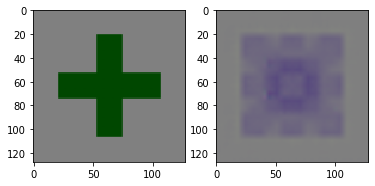

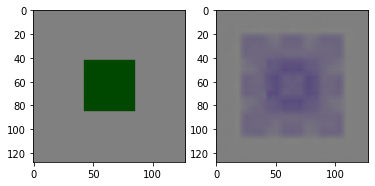

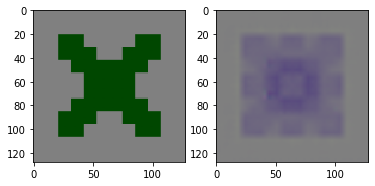

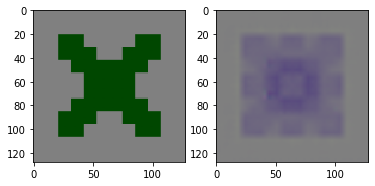

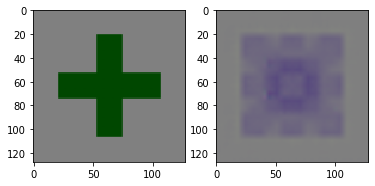

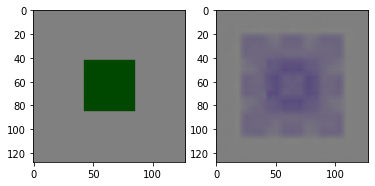

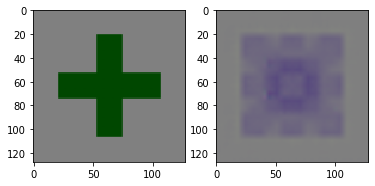

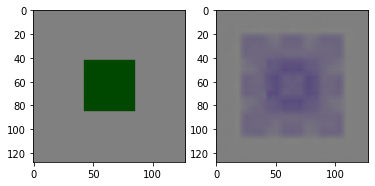

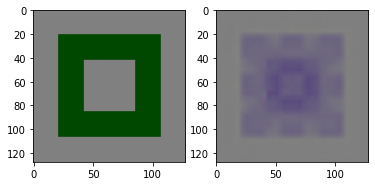

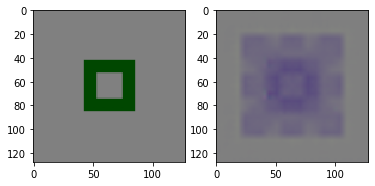

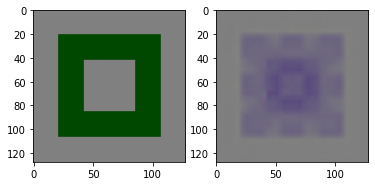

In [14]:
best_img_decoder = img_decoder
best_img_encoder = img_encoder
experiment = "variational-autoencoder-shapes"
show_img_count = 10
# best_img_decoder = ImageDecoder().to(device)
# best_img_encoder = ImageEncoder().to(device)

# best_img_decoder.load_state_dict(torch.load("img_decoder_{0}.pt".format(experiment), map_location=CFG.device))
# best_img_encoder.load_state_dict(torch.load("img_encoder_{0}.pt".format(experiment), map_location=CFG.device))


best_img_decoder.eval()
best_img_encoder.eval()
print(best_img_decoder.training)

count =0
with torch.no_grad():
    tqdm_object = tqdm(testloader, total=len(testloader))
    for images in tqdm_object:
        images = images.to(device)
        img_embeddings,mu,logvar = best_img_encoder(images)
        recon_imgs = best_img_decoder(img_embeddings)
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(images[0].squeeze().cpu().detach().permute(1,2,0),interpolation='nearest' )
        axarr[1].imshow(recon_imgs[0].cpu().detach().squeeze().permute(1,2,0),interpolation='nearest')
        plt.show()
        count = count + 1
        if count > show_img_count:
          break

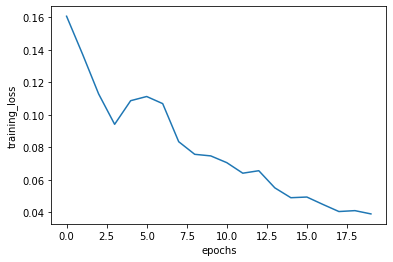

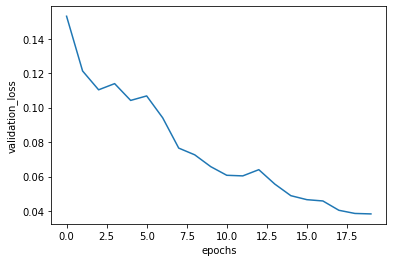

In [15]:
import pandas as pd
with open('metrics_{0}.pkl'.format(experiment), 'rb') as f:
    metrics = pkl.load(f)
    df = pd.DataFrame(metrics, columns =['epoch', 'training_loss', 'validation_loss'])
    plt.plot(df["epoch"], df["training_loss"])
    plt.xlabel("epochs")
    plt.ylabel("training_loss")
    plt.show()
    plt.plot(df["epoch"], df["validation_loss"])
    plt.xlabel("epochs")
    plt.ylabel("validation_loss")
    plt.show()


  0%|          | 0/47 [00:00<?, ?it/s]

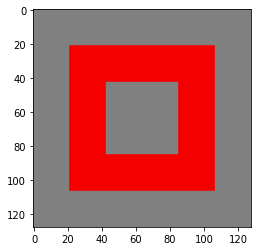

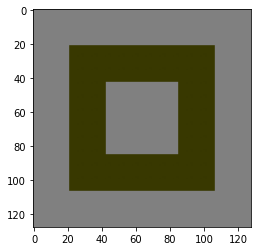

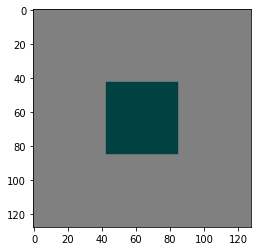

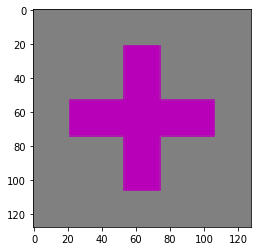

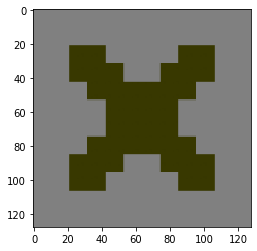

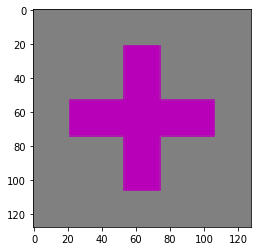

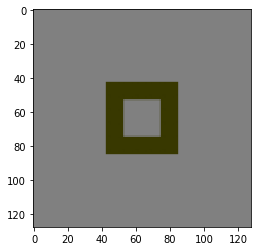

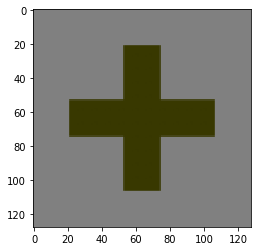

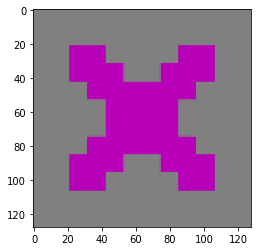

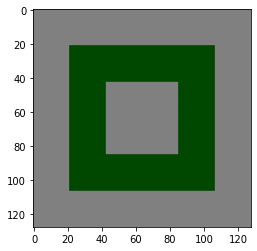

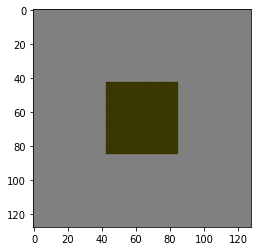

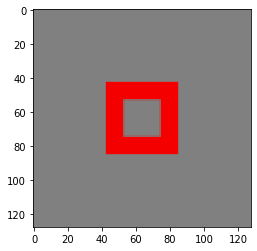

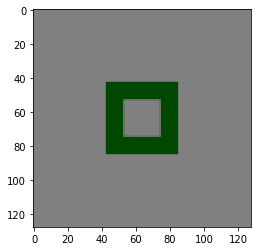

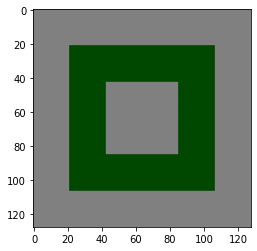

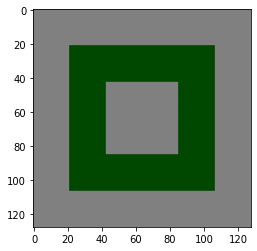

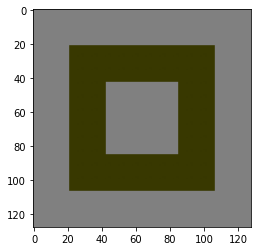

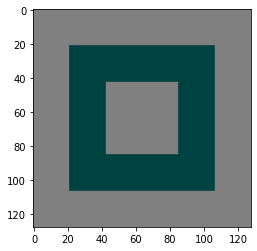

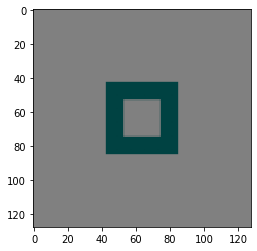

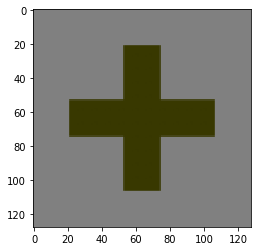

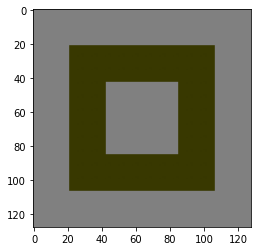

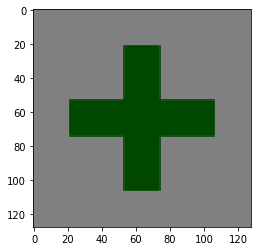

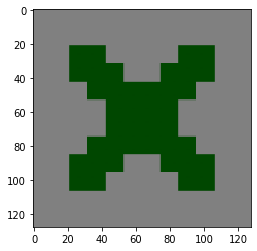

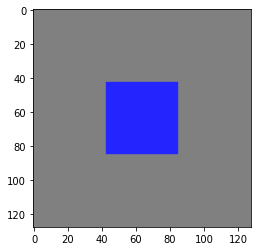

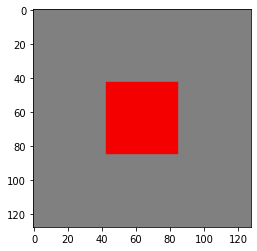

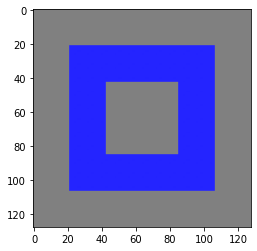

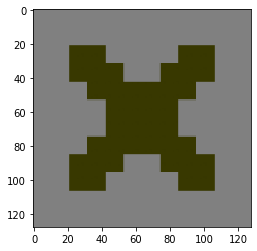

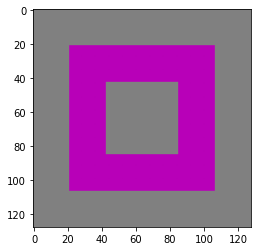

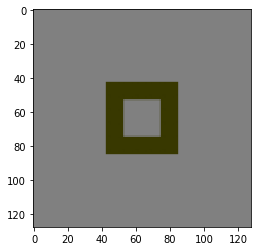

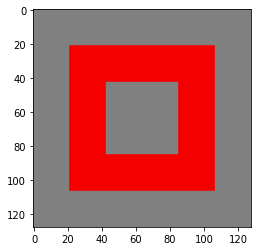

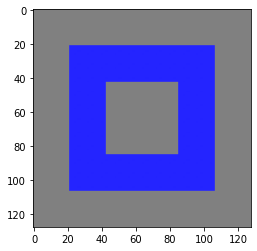

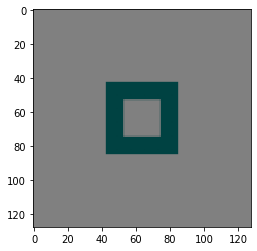

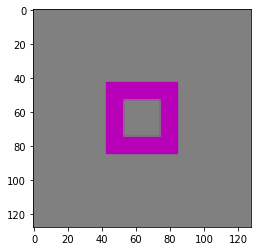

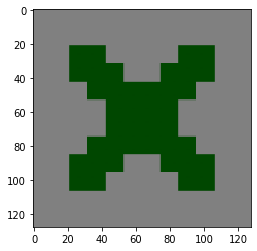

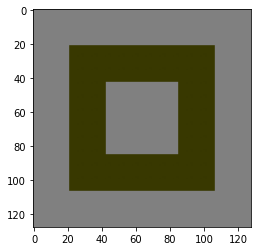

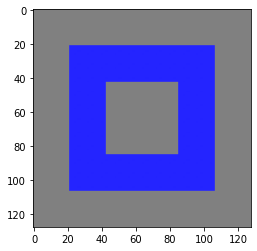

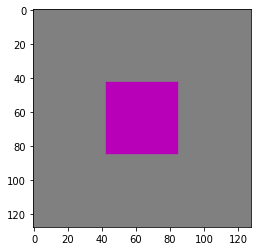

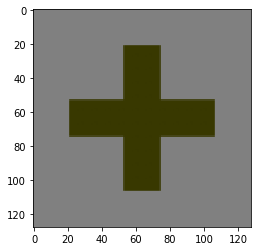

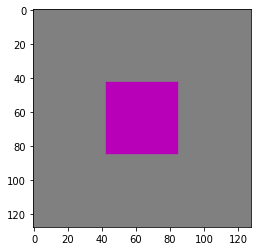

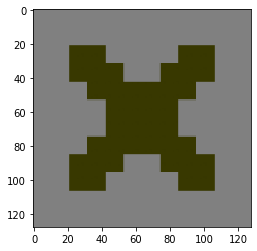

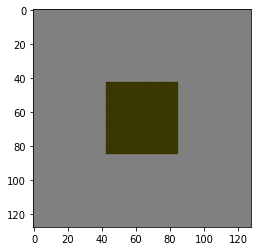

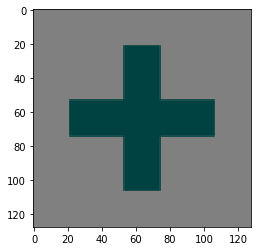

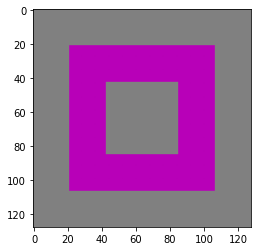

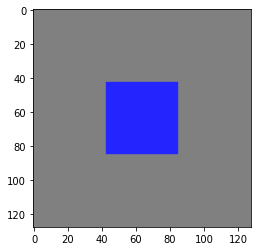

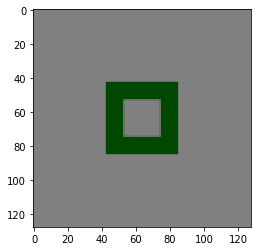

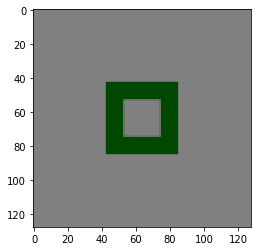

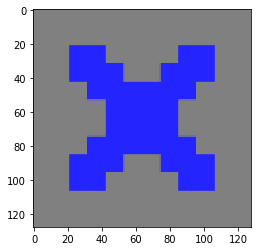

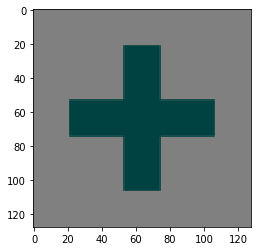

In [ ]:
with torch.no_grad():
  tqdm_object = tqdm(trainloader, total=len(trainloader))
  for images in tqdm_object:    
      images = images.to(device)
      plt.imshow(images[0].squeeze().permute(1,2,0), interpolation='nearest')
      plt.show()
      

  0%|          | 0/47 [00:00<?, ?it/s]

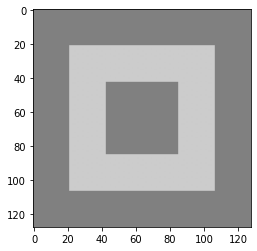

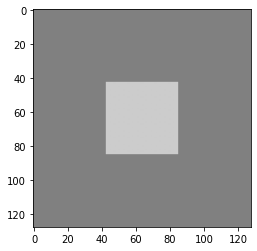

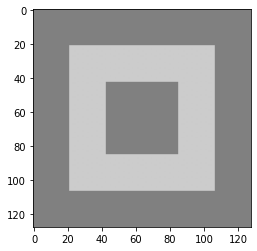

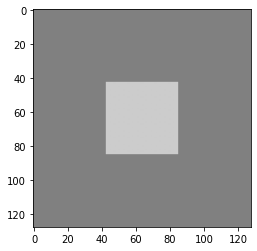

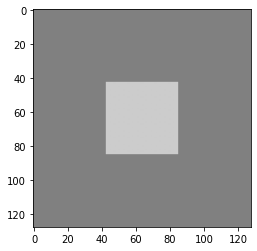

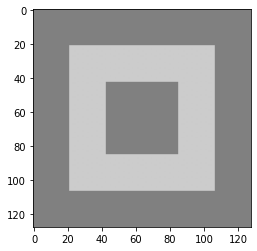

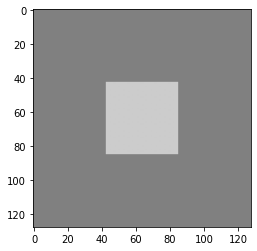

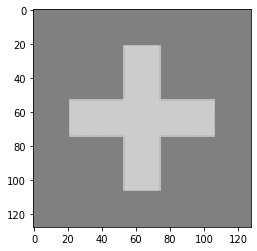

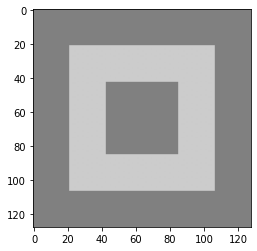

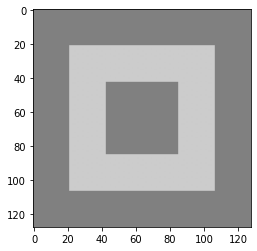

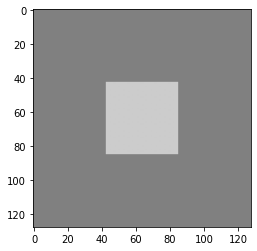

In [ ]:
count =0
with torch.no_grad():
    tqdm_object = tqdm(valloader, total=len(trainloader))
    for images in tqdm_object:
        images = images.to(device)
        # img_embeddings = best_img_encoder(images)
        # recon_imgs = best_img_decoder(img_embeddings)
        plt.imshow(images[0].squeeze().permute(1,2,0), interpolation='nearest')
        plt.show()
        # f, axarr = plt.subplots(1,2)
        # axarr[0].imshow(images[0].squeeze().cpu().detach().permute(1,2,0),interpolation='nearest' )
        # axarr[1].imshow(recon_imgs[0].cpu().detach().squeeze().permute(1,2,0),interpolation='nearest')
        plt.show()
        count = count + 1
        if count > show_img_count:
          break